Ising with nearest-neighbor interactions

Assign energies to each state.

States: 
- closed, adjacent closed (zero energy)
    - 1 adjacent up (x2?)
    - 2 adjacent up
- open, adjacent closed ($\epsilon$ energy)
    - 1 adjacent up
    - 2 adjacent up

All closed is minimum energy. Low energy is higher probability? At what temp does it work out at?

Partition function of one state:

$$
Z = \sum_s e^{-\epsilon_s/\tau} \\
\epsilon_{0,0} = 0 \\
\epsilon_{0,1} = a \\ %not sure what these are yet
\epsilon_{0,2} = b \\
\epsilon_{1,0} = \epsilon + c\\
\epsilon_{1,1} = \epsilon + d \\
\epsilon_{1,2} = \epsilon \\

P(s,n) = \frac{e^{-\epsilon_{s,n}/\tau}}{e^{-\epsilon_{0,n}} + e^{-\epsilon_{1,n}}} \\
$$

Really there is only two states, but state energy updates each round. We'll use a markov chain to monitor these.

Edges: use open vals



Can we induct it down? break into 2 pieces? Course graining makes fewer degrees of freedom by "averaging", certain parameters can make this useful. "Real Space Renormalization". 

Assumptions for our current system:

Canonical ensemble: any two states can happen. Needs large time steps (seconds vs microsecond interactions)

Transformation from full partition into product of single particles? Need to do some googling first. Someone else has done it clever before. Some kind of linear combination, some kind of forier? Waves on a string decouples into modes. Could be fun.



0.8021838885585821
0.606436301651586
0.6185228677648262
0.6020273218651173
0.5850342935104595
0.5705294668596477
0.627483077957621
0.5639175760381504
0.5947033885152312
0.6020281112942203


<Axes: >

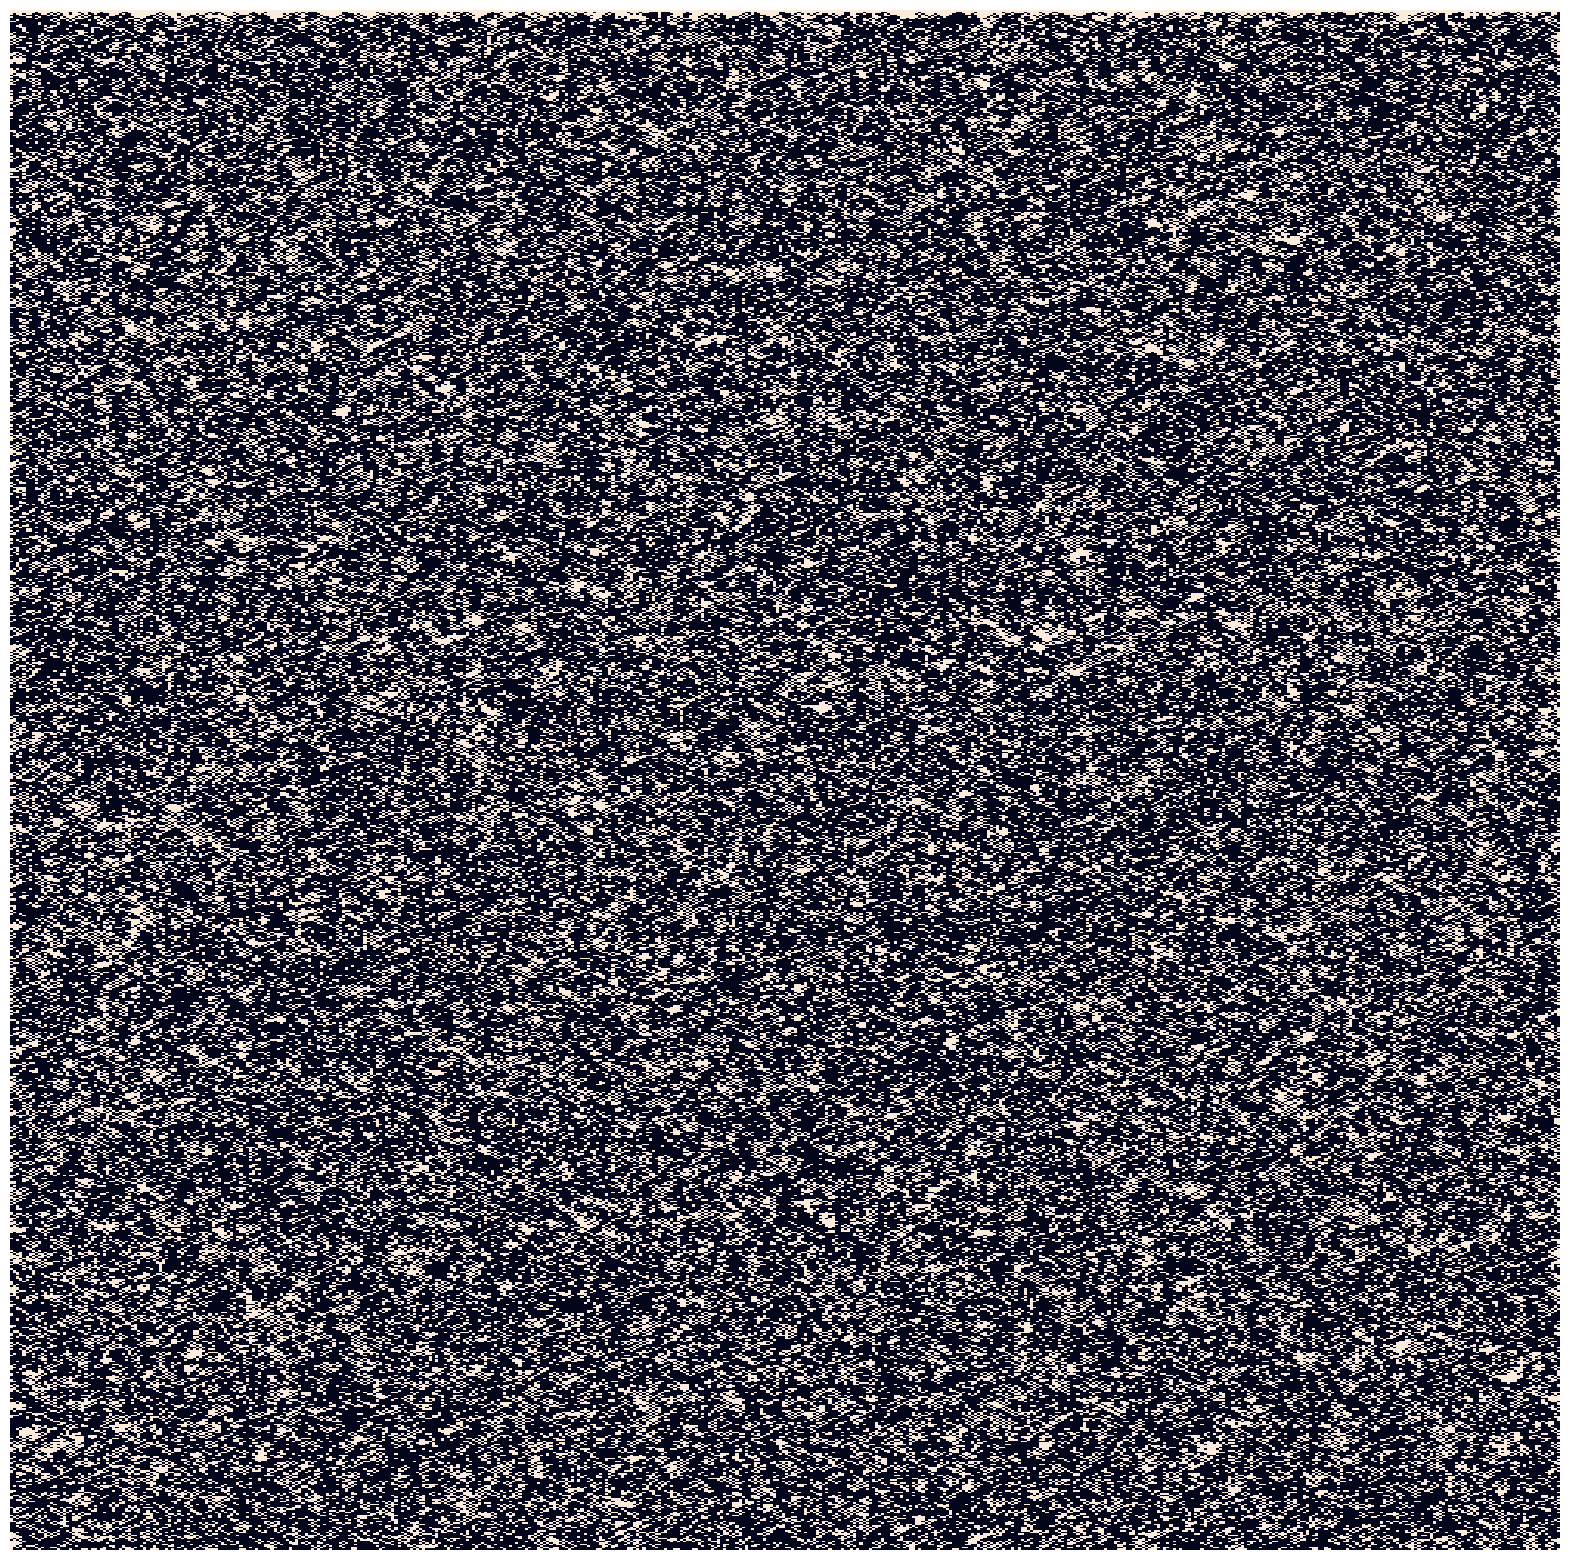

In [342]:
import numpy as np
from numpy import exp
from scipy.constants import k
import seaborn as sns
import matplotlib.pyplot as plt

#Temp = 20 # °C
#tau = k*(Temp + 273.15)
tau=5
a = 1
b = a*2
d = 1
c = d*2
epsilon = 5

Z_table = np.array([
    [1, exp(-a/tau), exp(-b/tau)],
    [exp(-(epsilon+c)/tau), exp(-(epsilon+d)/tau), exp(epsilon/tau)]
])

#Z_table = np.array([
#    [1000, 1, 1],
#    [1, 1.2, 100]
#])

n = 500 #chain length
chain = np.ones(n, dtype=int)
neighbors = np.zeros(n, dtype=int)
chain_list = [chain.copy()]

for i in range(1000):

    
    neighbors[1:-1] = chain[2:] + chain[:-2]
    neighbors[0] = 1 + chain[1]
    neighbors[-1] = 1 + chain[-2]

    probability_threshold = Z_table[chain, neighbors] / Z_table.sum(axis=0)[neighbors] # probability to stayin current state
    if i % 100 == 0:
        print(probability_threshold.mean())
    state_change = np.random.rand(n)>probability_threshold
    chain[state_change] = 1-chain[state_change]

    #if i == 20:
    #    chain[200:210] = 0

    chain_list.append(chain.copy())

plt.figure(figsize=(20,20))
sns.heatmap(np.array(chain_list), xticklabels=False, yticklabels=False, cbar=False)

<Axes: >

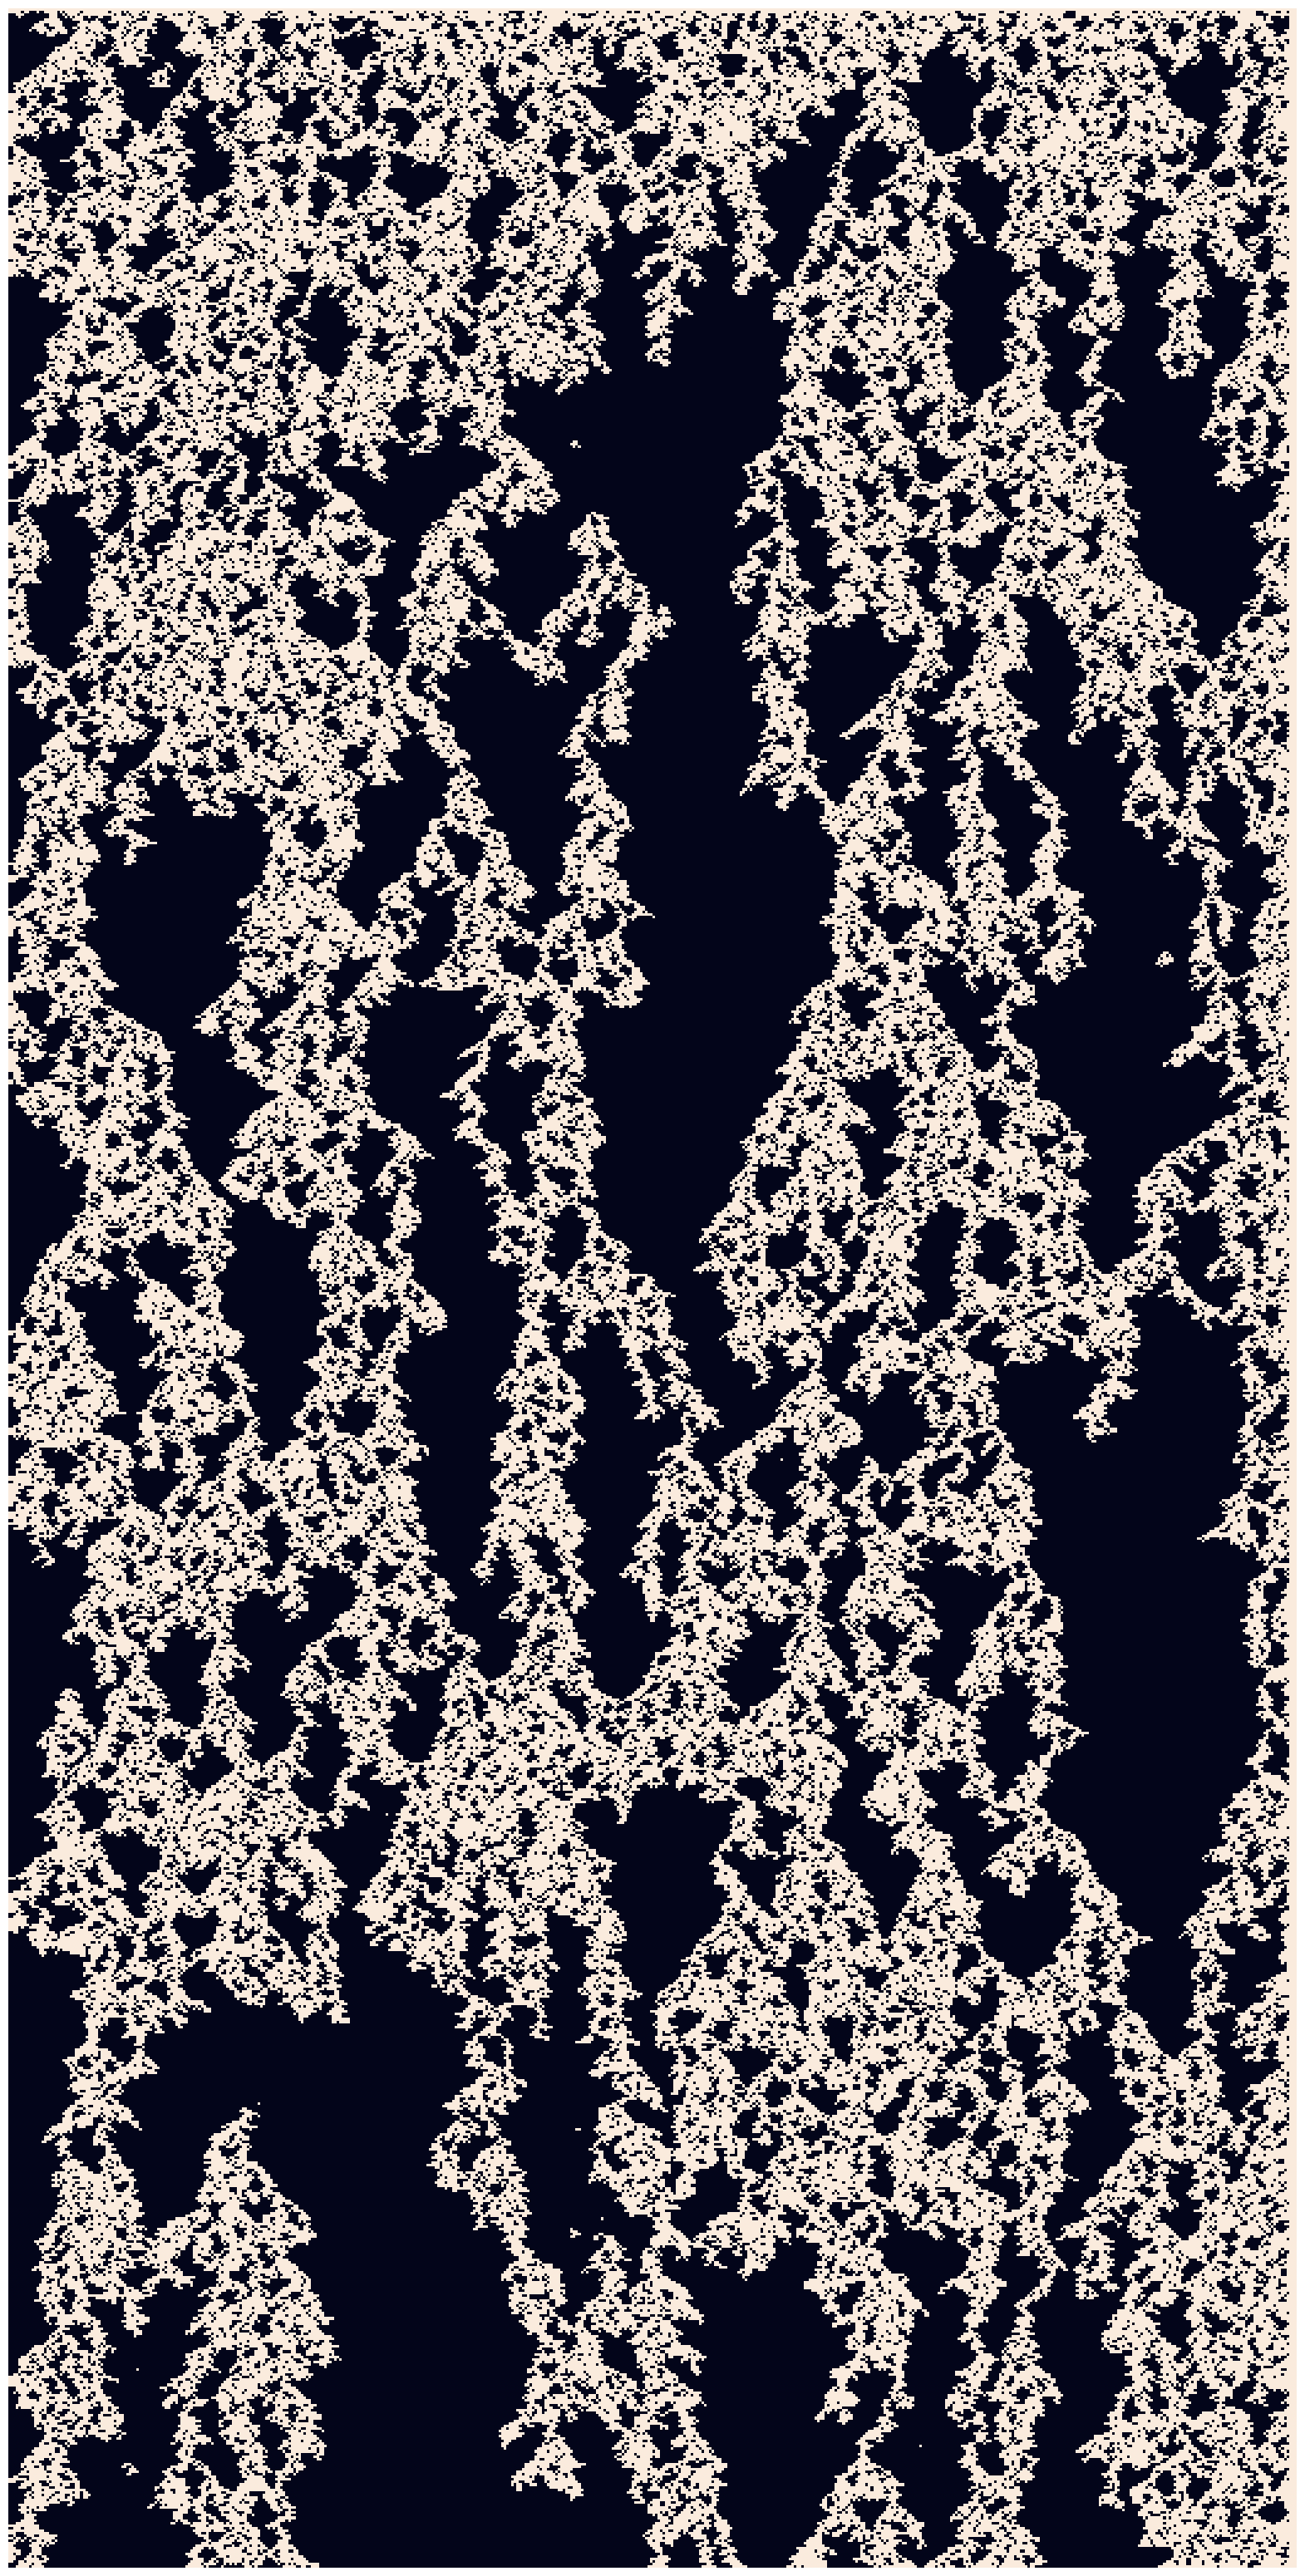

In [ ]:
# Try to use random update order instead of simultaneous update -> breaks up checkerboard
rng = np.random.default_rng()

Z_table = np.array([
    [10000, 1, 1],
    [1, 2, 5]
])

n = 500 #chain length
random_order = np.arange(1,n-1) # boundary conditions
chain = np.ones(n+2, dtype=int)
chain_list = [chain.copy()]

for i in range(1000): # time steps
    rng.shuffle(random_order)
    
    for i in random_order:
        neighbors = chain[i-1] + chain[i+1]
        probability_threshold = Z_table[chain[i], neighbors] / Z_table.sum(axis=0)[neighbors] #p of staying in current state
        chain[i] = chain[i] ^ (probability_threshold<np.random.rand())

    chain[0] = chain[1] #edge is just the same as neighbor state
    chain[-1] = chain[-2]

    chain_list.append(chain.copy())

plt.figure(figsize=(20,40))
sns.heatmap(np.array(chain_list), xticklabels=False, yticklabels=False, cbar=False)

# other stuff

---

In [30]:
import cirq

# Define two qubits
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)

# Define the |01> state
initial_state = [0, 1, 0, 0]  # |01>

# Define the XX + YY operator using Cirq's PauliString
xx = cirq.PauliString(cirq.X(q0) * cirq.X(q1))
yy = cirq.PauliString(cirq.Y(q0) * cirq.Y(q1))

# Combine XX + YY
operator = xx + yy

# Create a circuit to apply the operator
circuit = cirq.Circuit()

# Prepare the initial state |01> using single-qubit gates
circuit.append(cirq.X(q1))  # Flip q0 to |1> (now |01>)

circuit.append(operator)

## Add the XX + YY operator as a gate
#circuit.append(cirq.PauliSumExponential(operator, exponent=1.0))
#
# Simulate the circuit
simulator = cirq.Simulator()
result = simulator.simulate(circuit, initial_state=initial_state)

# Print the final state vector
print("Final state vector after applying XX + YY:")
print(result.final_state_vector)

Final state vector after applying XX + YY:
[-1.+0.j  0.+0.j  0.+0.j  0.+0.j]


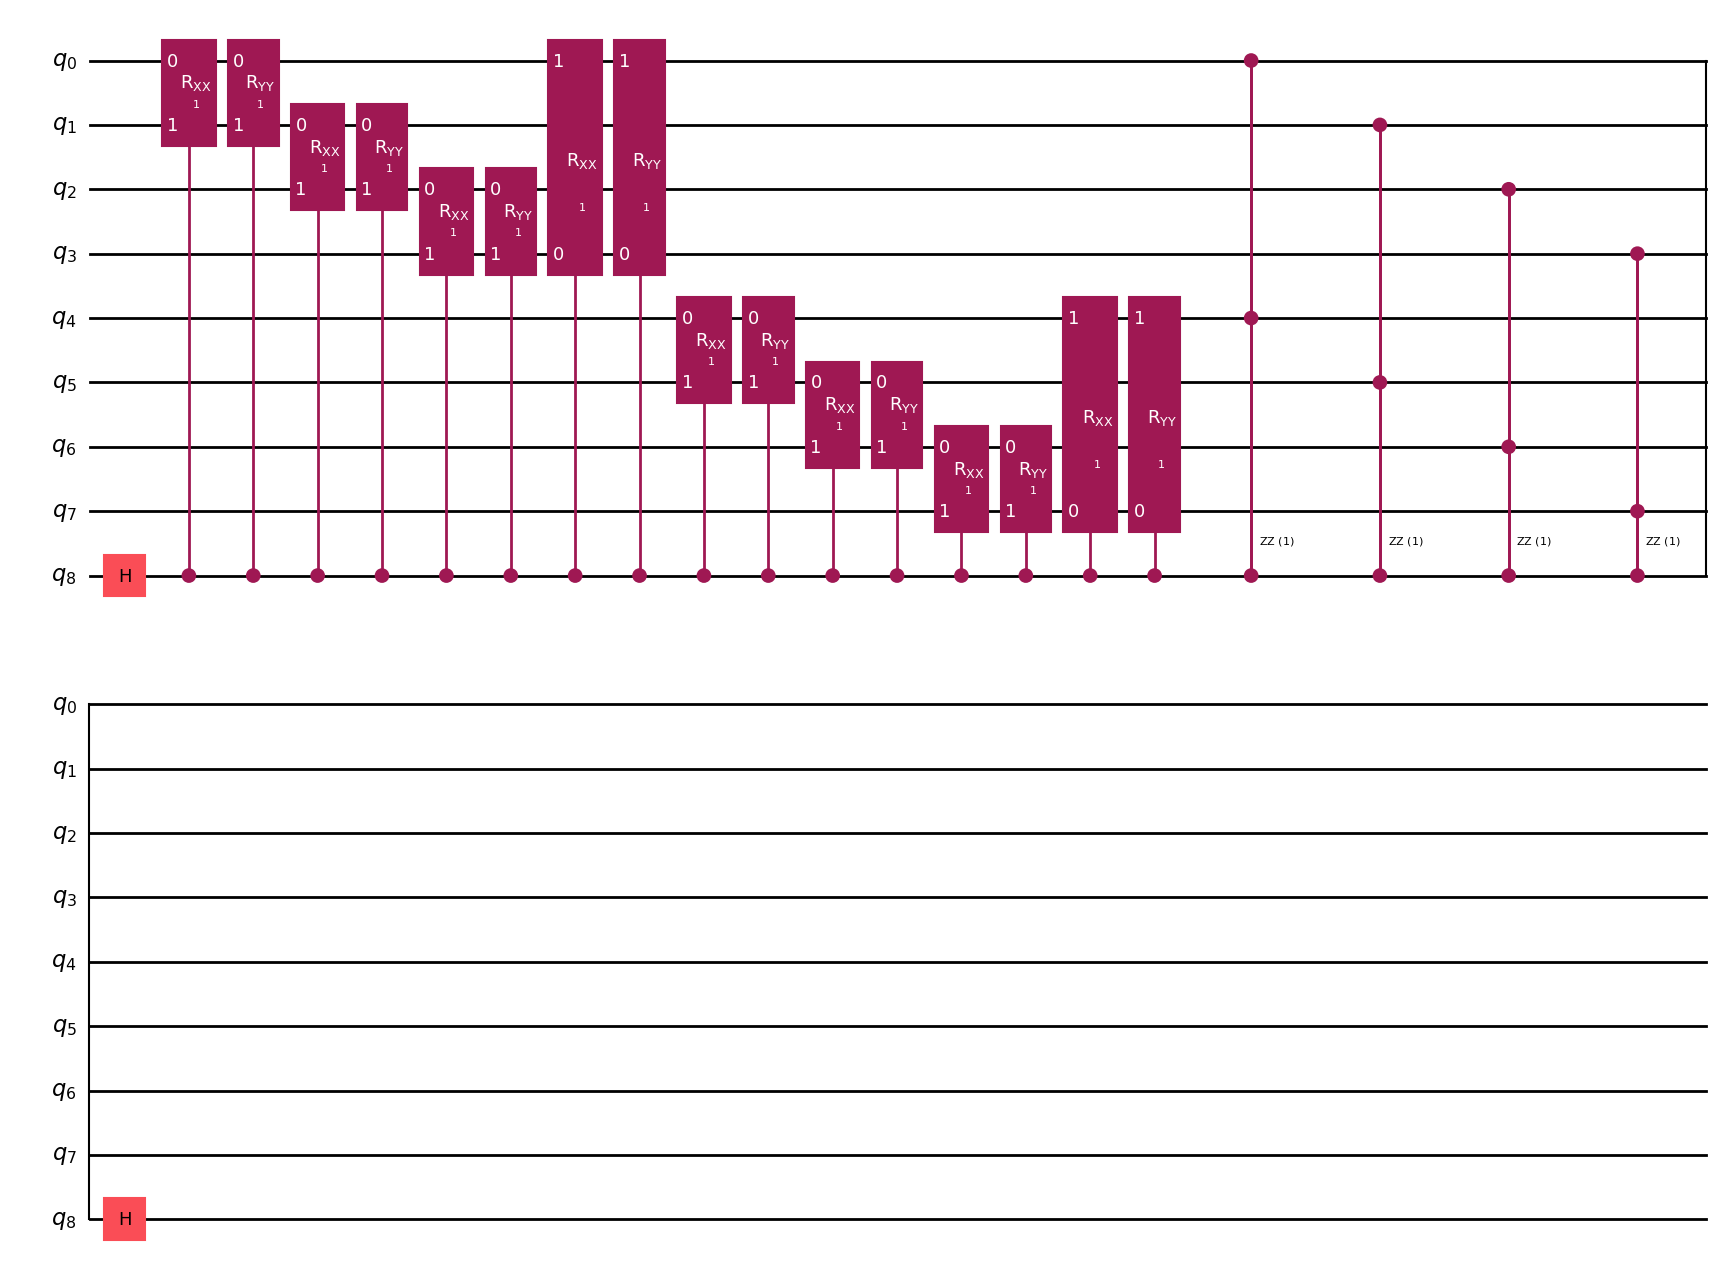

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate

def controlled_XX_YY(qc, ancilla, q1, q2, t):
    """Applies controlled-RXX and controlled-RYY gates."""
    qc.append(RXXGate(2*t).control(1), [ancilla, q1, q2])
    qc.append(RYYGate(2*t).control(1), [ancilla, q1, q2])

def controlled_ZZ(qc, ancilla, q1, q2, t):
    """Applies controlled-RZZ gate."""
    qc.append(RZZGate(2*t).control(1), [ancilla, q1, q2])

N = 4  # Number of qubits per ring
qc = QuantumCircuit(2 * N + 1)  # Extra qubit for the ancilla

ancilla = 2 * N  # The last qubit is the ancilla

# Initialize ancilla in |+> state for potential applications
qc.h(ancilla)

# First ring: controlled XX + YY interactions
for i in range(N):
    controlled_XX_YY(qc, ancilla, i, (i+1) % N, t=0.5)

# Second ring: controlled XX + YY interactions
for i in range(N):
    controlled_XX_YY(qc, ancilla, i + N, (i+1) % N + N, t=0.5)

# Inter-ring controlled ZZ interactions
for i in range(N):
    controlled_ZZ(qc, ancilla, i, i + N, t=0.5)

# Apply Hadamard to ancilla again if using phase estimation
qc.h(ancilla)

qc.draw('mpl')


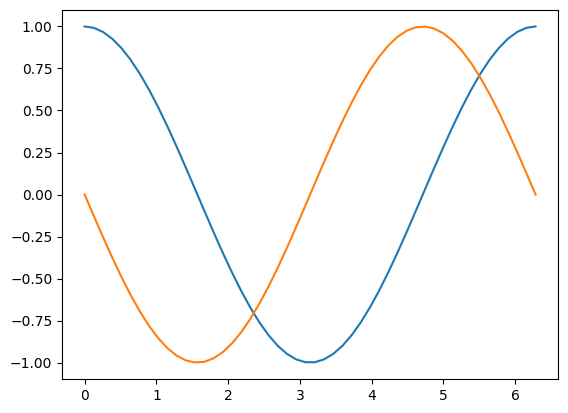

In [12]:
from numpy import exp, linspace, pi
import matplotlib.pyplot as plt
x = linspace(0, 2*pi)
result = exp(-1j*x)

plt.plot(x, result.real)
plt.plot(x, result.imag)